In [1]:
import matplotlib.pyplot as plt

# pyqubo imports
from pyqubo import Binary, Array

#myqlm imports
from qat.plugins import ScipyMinimizePlugin
from qat.qpus import get_default_qpu
from qat.core import Observable, Term

import networkx as nx

/home/omp/anaconda3/envs/QML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Problema do K-Clique

O Problema do K-Clique consiste em encontrar um subgrafo completo, $\hat{G}$, composto por $K$ vértices (nós), em um dado grafo $G(V,E)$. Um grafo é completo quando todos os seus vértices nós interconectados. Na figura abaixo, podemos ver um grafo e seu respectivo clique de tamanho $K=4$.

<img src="imagens/grafo_clique.png" width=750 />



É possível verificar que o conjunto dos vértices $|V_c| = \{0,1,2,3\} $ formam um clique de tamanho $K=4$, pois formam um grafo completo. 

### Exercício 1:

Codifique o grafo da figura anterior e desenhe-o usando o framework `Networkx`.

Graph with 5 nodes and 8 edges


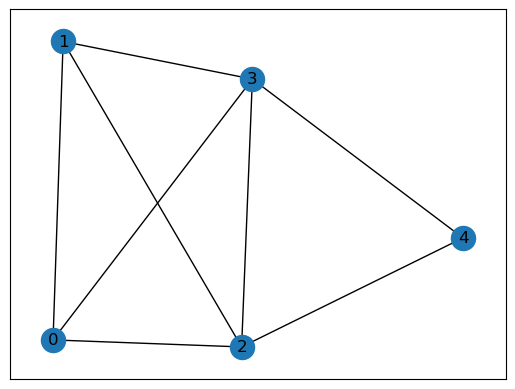

In [2]:
# Crie uma estrutura que codifique o grafo
G = nx.Graph()

# Crie uma lista com os indices de cada nó
nodes = [i for i in range(5)]

# Crie uma lista de tuplas com os nos vizinhos: g=[..., (ni,nj),...]
e = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3),(2,4),(3,4)]

G.add_nodes_from(nodes)
G.add_edges_from(e)
nx.draw_networkx(G, with_labels=True)
print(G)

### Exercício 2:

Defina os parâmetros do problema. Note que queremos encontrar um clique de tamanho $K=4$ no grafo dado como exemplo.

In [3]:
# Defina o tamanho do clique
K = 4

# Numero de nos do grafo
num_nodes = len(nodes)

print(f"Tamanho do Clique: {K}\nNúmero de nós: {num_nodes}")


Tamanho do Clique: 4
Número de nós: 5


## Formulação como Otimização Irrestrita

O problema do K-clique pode ser formulado como uma função de otimização com variáveis binárias, $x_i \in \{0,1\}$. Se $x_i = 1$, indica que o vértice de índice $i$ faz parte do clique. A solução do exemplo com o grafo apresentado anteriormente é dada por $\vec{x} = 11110$, visto que apenas o vértice $4$ não faz parte do clique.

Existem dois termos de penalidades necessários para escrever o Problema do Clique como Otimização Irrestrita. Um dos termos está relacionado ao fato de que o número de vértices no estado $x_i = 1$ deve ser igual a $K$. Ele é representado por

$$ H_a = \left(K - \sum_{i=0}^{N}x_i\right)^2. $$

Quanto maior a diferença entre $K$ e o número de vértices em estado $1$, maior será a penalidade na função objetivo. O valor de $H_a$ será $0$ (mínimo) quando o critério for atendido.

Essa condição, no entanto, não é suficiente para garantir que o clique seja encontrado. Para isso é preciso considerar outros aspectos do clique, como a quantidade de arestas. Essa quantidade é dada por

$$E = \frac{K(K-1)}{2}.$$

Logo, é necessário um novo termo na função objetivo, cujo papel desempenhado é o de penalizar a função caso o número de arestas do subgrafo que conectam os nós de estado $x_i = 1$ seja diferente de $E$. A quantidade de arestas do clique deve ser igual a $E$, portanto o termo de penalidade é

$$H_b = E - \sum_{<ij>}x_ix_j$$

onde $<ij>$ representa os índices apenas dos vértices conectados entre si.

Juntos dos termos são definidas as variáveis de penalidade dadas por $A$ e $B$, que são números inteiros usados para controlar a função objetivo e garantir que as restrições serão atendidas. Sendo assim, a função objetivo final é dada por 

$$H = A\left(K - \sum_{i=0}^{N}x_i\right)^2 + B\left( C - \sum_{<ij>}x_ix_j\right).$$

Neste problema, devemos considerar as constantes de penalidade satisfaznedo $A > B$.


### QLM Problem Generator

myQLM fornece geradores de batch usados para gerar um quantum job (usado para resolver um problema combinatório) e analisar o resultado para retornar uma estrutura de dados legível.

Esses geradores em batch podem gerar diferentes tipos de jobs, para serem compatíveis com diferentes tipos de QPUs. Os diferentes tipos de job são:

  - QAOA jobs
  - Annealing Jobs
  - Analog Jobs

Por questões didáticas, focaremos nesse Hands-on nos QAOA jobs

O `KCliqueGenerator` pode ser usado para gerar batchs para resolver o problema K-Clique em um gráfico de entrada.

Para isso gera-se uma stack do problema composta por:

$$\text{Gerador}\>|\>\text{Optimizer}\>|\>\text{QPU}$$

In [4]:
from qat.generators import KCliqueGenerator

scipy_args = dict(method="COBYLA", tol=1e-5, options={"maxiter": 200})
kclique_application = KCliqueGenerator(job_type="qaoa") | (ScipyMinimizePlugin(**scipy_args) | get_default_qpu())

Com a aplicação criada, chama-se o método `execute` passando os parâmetros necessários para a resolução do problema.

### Exercício 3:

Escreva as variáveis de penalidade para os termos $H_a$ e $H_b$ do Hamiltoniano do problema.

In [5]:
# Penalidades para Ha e Hb
A = 4
B = 1
print(f"Constantes de penalidade: {A} e {B}.")


combinatorial_result = kclique_application.execute(G, K, A, B)

Constantes de penalidade: 4 e 1.


/tmp/ipykernel_23103/285792882.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  combinatorial_result = kclique_application.execute(G, K, A, B)


O objeto retornado pelo `execute` é um tipo específico de `Result` que contém tanto a solução do problema quanto a energia mínima do Hamiltoniano.

The nodes of the complete subgraph are [0, 1, 2, 3]
-70.0


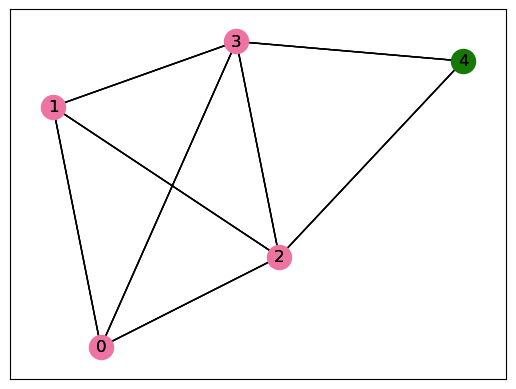

In [6]:
print("The nodes of the complete subgraph are", combinatorial_result.clique)
print(combinatorial_result.cost)
combinatorial_result.display()

# Problema do Max Cut

Para um grafo, um corte máximo é um corte cujo tamanho é de pelo menos o tamanho de qualquer outro corte. O problema de encontrar um corte máximo em um grafo é conhecido como Problema do Corte-Máximo (Max-Cut).

O problema pode ser descrito simplesmente como segue. Deseja-se um subconjunto S do conjunto de vértices tal que o número de arestas entre S e o subconjunto complementar é tão grande quanto possível.

![MaxCut](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/Max-cut.svg/200px-Max-cut.svg.png)

### Exercício 4

Crie um grafo que será usado para o Max Cut

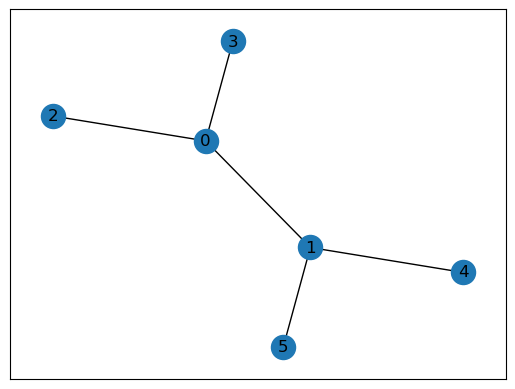

In [7]:
graph = nx.full_rary_tree(3, 6)
nx.draw_networkx(graph)

In [8]:
from qat.generators import MaxCutGenerator

scipy_args = dict(method="COBYLA", tol=1e-5, options={"maxiter": 200})
max_cut_application = MaxCutGenerator(job_type="qaoa") | (ScipyMinimizePlugin(**scipy_args) | get_default_qpu())

In [9]:
combinatorial_result = max_cut_application.execute(graph)
print("The nodes in the first subgraph are", combinatorial_result.subsets[0])
print("The nodes in the second subgraph are", combinatorial_result.subsets[1])
# The cost here is negative since all combinatorial optimization problems are defined as a minimization problem, so a factor of -1 is needed
print("The number of edges that are cut is", -1 * combinatorial_result.cost)

/tmp/ipykernel_23103/2872952381.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  combinatorial_result = max_cut_application.execute(graph)


The nodes in the first subgraph are [0, 4, 5]
The nodes in the second subgraph are [1, 2, 3]
The number of edges that are cut is 5.0


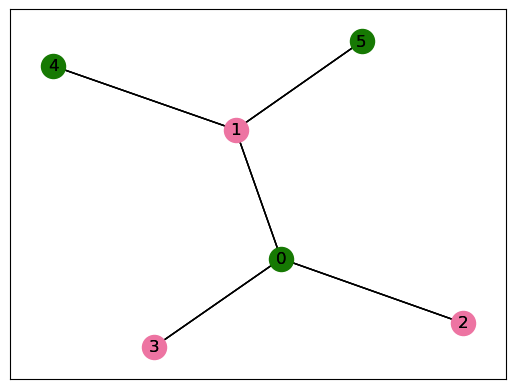

In [10]:
combinatorial_result.display()

Atualmente QLM só possui disponível os ```Problem Generators``` dos problemas abaixo:

 - Max Cut
 - Vertex Cover
 - Graph Partitioning
 - Graph Colouring
 - K-clique